In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Exploratory Data Analysis

## Reading dataset

__Observation__:
- From looking at the dataset documentation we observe that many of the categorical features contain a value which can be 'NA' or 'None' string. By default `pd.read_csv` would interpret this as a missing values which is not the case.

__Solution__:
- Change the list of strings to be intepreted as missing values

In [75]:
file ='house-prices.csv'
df = pd.read_csv(file, na_values = [''],keep_default_na=False)
df.drop(['Order', 'PID'], axis=1, inplace=True)

In [76]:
df.isna().sum().sum()

11670

In [77]:
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,20,RL,75.00,10170,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,160,RM,21.00,2001,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,20,RL,70.00,10552,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,190,RM,60.00,10120,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


In [78]:
df.shape

(2430, 80)

__Observation__:
- There are 80 features and 2430 entries
- We observe there's a mix of categorical and numerical features

Data types of the different columns in the dataset:

In [79]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [80]:
continuous_features = df.dtypes[df.dtypes == 'float64'].index
continuous_features

Index(['Lot Frontage', 'Mas Vnr Area', 'BsmtFin SF 1', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath',
       'Garage Yr Blt', 'Garage Cars', 'Garage Area'],
      dtype='object')

In [81]:
discrete_features = df.dtypes[df.dtypes == 'int64'].index
discrete_features

Index(['MS SubClass', 'Lot Area', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Misc Val', 'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

In [82]:
categorical_features = df.dtypes[df.dtypes == 'object'].index
categorical_features

Index(['MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour',
       'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature',
       'Sale Type', 'Sale Condition'],
      dtype='object')

__Observation__:
- Comparing the data types with the documentation about the dataset we observe the following mismatches:
- Variables that should be categorical: __'MS SubClass'__;
- Variables that should be continuous : __'Lot Area', '1st Flr SF', '2nd Flr SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch','3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val'and 'SalePrice'__;
- Variables that should be discrete   : __'Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars'__;
- Observing the values of the variables that should be discrete we see that see take only integer values as expected;
  
__Solution__:
- We convert the datatypes of all the above variables to the correct ones;
- For the discrete variables (`int64`) we first convert all the variables to `Int64`, since only this integer datatype supports `NA` values;

In [83]:
# Convert to Categorical
df['MS SubClass'] = df['MS SubClass'].astype(str)

# Convert to Discrete (but first convert all int64 to Int64 )
for col in discrete_features:
        df[col] = df[col].astype('Int64')

# Convert to Continuous
convert_to_continuous = ['Lot Area', '1st Flr SF', '2nd Flr SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch','3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'SalePrice']
for col in convert_to_continuous:
        df[col] = df[col].astype('float64')


convert_to_discrete = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Yr Blt', 'Garage Cars']
for col in convert_to_discrete:
        df[col] = df[col].astype('Int64')


We obtain again the list of datatypes after the conversions:

In [84]:
continuous_features = df.dtypes[df.dtypes == 'float64'].index
discrete_features = df.dtypes[df.dtypes == 'Int64'].index
categorical_features = df.dtypes[df.dtypes == 'object'].index

Next we'll perform the data cleaning operations (Incorrect and missing values, inconsistencies, and outliers) for each datatype separately.

## Categorical Features

In [85]:
print(f'Number of categorical features: {len(categorical_features)}')

Number of categorical features: 43


### Missing values:

In [86]:
print(f'Total missing values: {df[categorical_features].isna().sum().sum()}')

Total missing values: 11082


In [87]:
df_categorical_missing = df[categorical_features].isna().sum().to_frame(name='total')
df_categorical_missing = df_categorical_missing[df_categorical_missing['total']!=0].sort_values('total', ascending=False)
df_categorical_missing['percentage'] = df_categorical_missing['total']/len(df)*100
df_categorical_missing

,total,percentage
Pool QC,2418,99.51
Misc Feature,2340,96.30
Alley,2267,93.29
Fence,1941,79.88
Fireplace Qu,1186,48.81
Garage Finish,138,5.68
Garage Qual,138,5.68
Garage Cond,138,5.68
Garage Type,136,5.60
Bsmt Exposure,74,3.05


__Observation__:
- Except for 'Electrical' all other features have a value which corresponds to 'None' according to the dataset doc 
- From a quick check of the original CSV file, it is highly probable that these missing values should instead be 'None', corresponding to cases where such a feature is not present

__Solution__:
- Replace the missing value for 'Electrical' with the mode
- Replace the missing values of remaining features with 'NA'
- Replace all existing values of 'None' with 'NA'

In [88]:
# Replace missing values with the mode
mode_value = df['Electrical'].mode()[0]
df['Electrical'].fillna(mode_value, inplace=True)

In [89]:
# Replace missing values with 'None'
df[categorical_features] = df[categorical_features].fillna('NA')
df[categorical_features].replace('None','NA', inplace=True)

In [90]:
print("Missing values in categorical columns after cleaning: ", df[categorical_features].isna().sum().sum())

Missing values in categorical columns after cleaning:  0


### Feature distribution:

We next observe the distribution of all the features

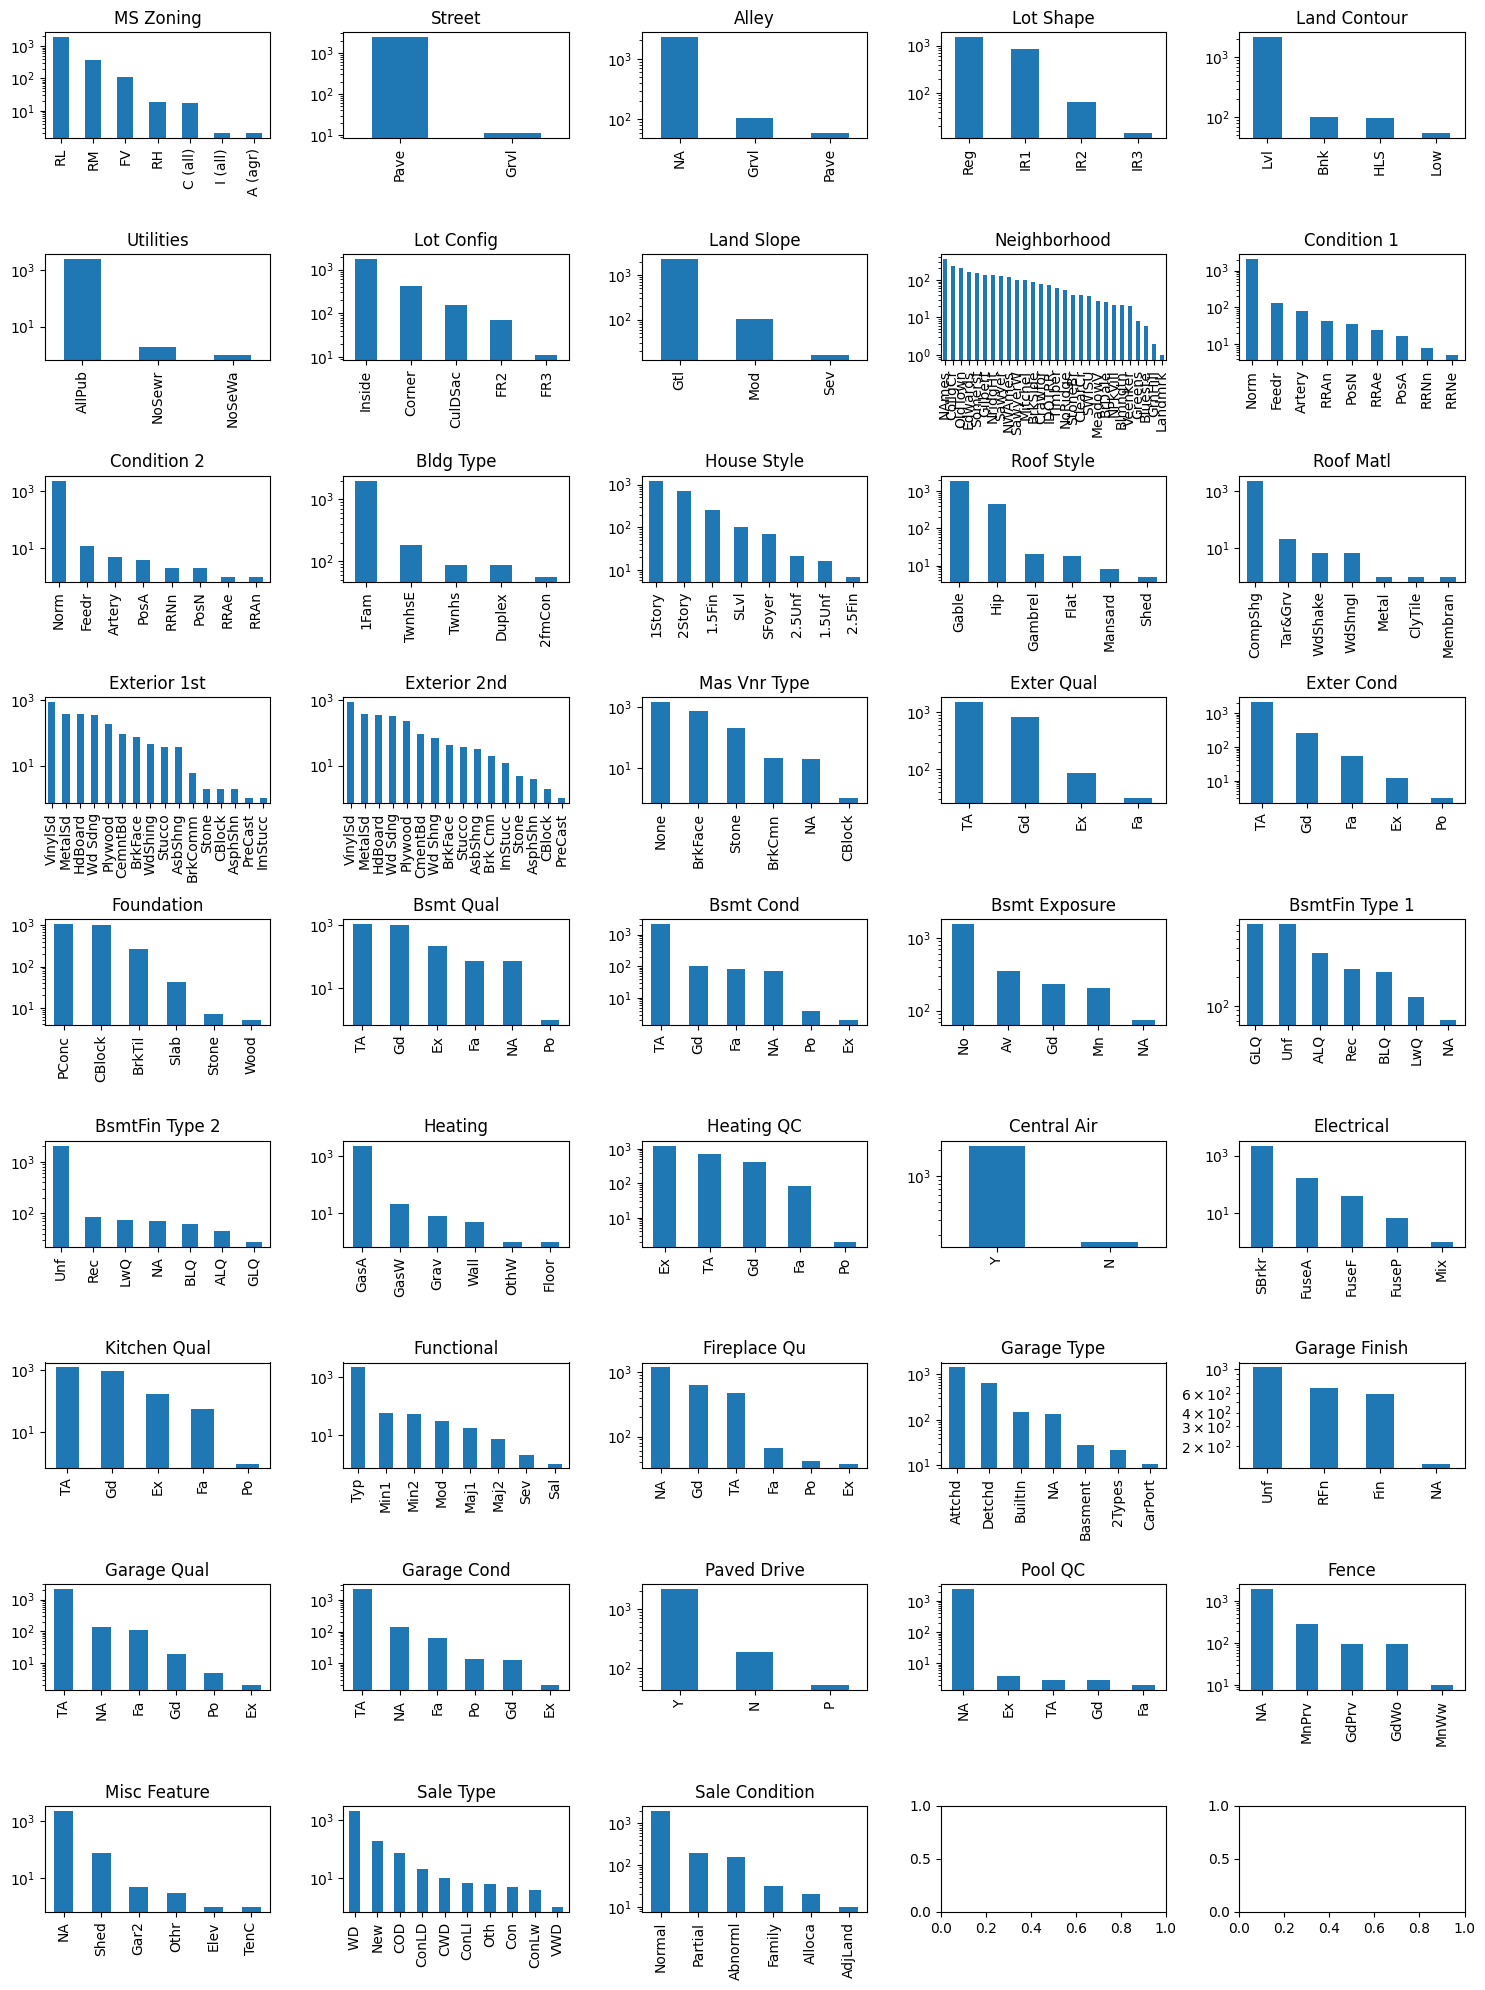

In [91]:
n_cols = 5
n_rows = 9

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 20))

for i, col in enumerate(categorical_features):
    r, c = np.divmod(i, n_cols)
    df[col].value_counts().plot(kind='bar', ax=axs[r, c], logy=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

__Observation__
- For most features there's a a difference in 1 or more orders of magnitude between most and least frequent values
- For the cate of categorical variables it doesn't make sense to talk about outlier points, since all values are in principle accepted as valid

### Relationship with target variable

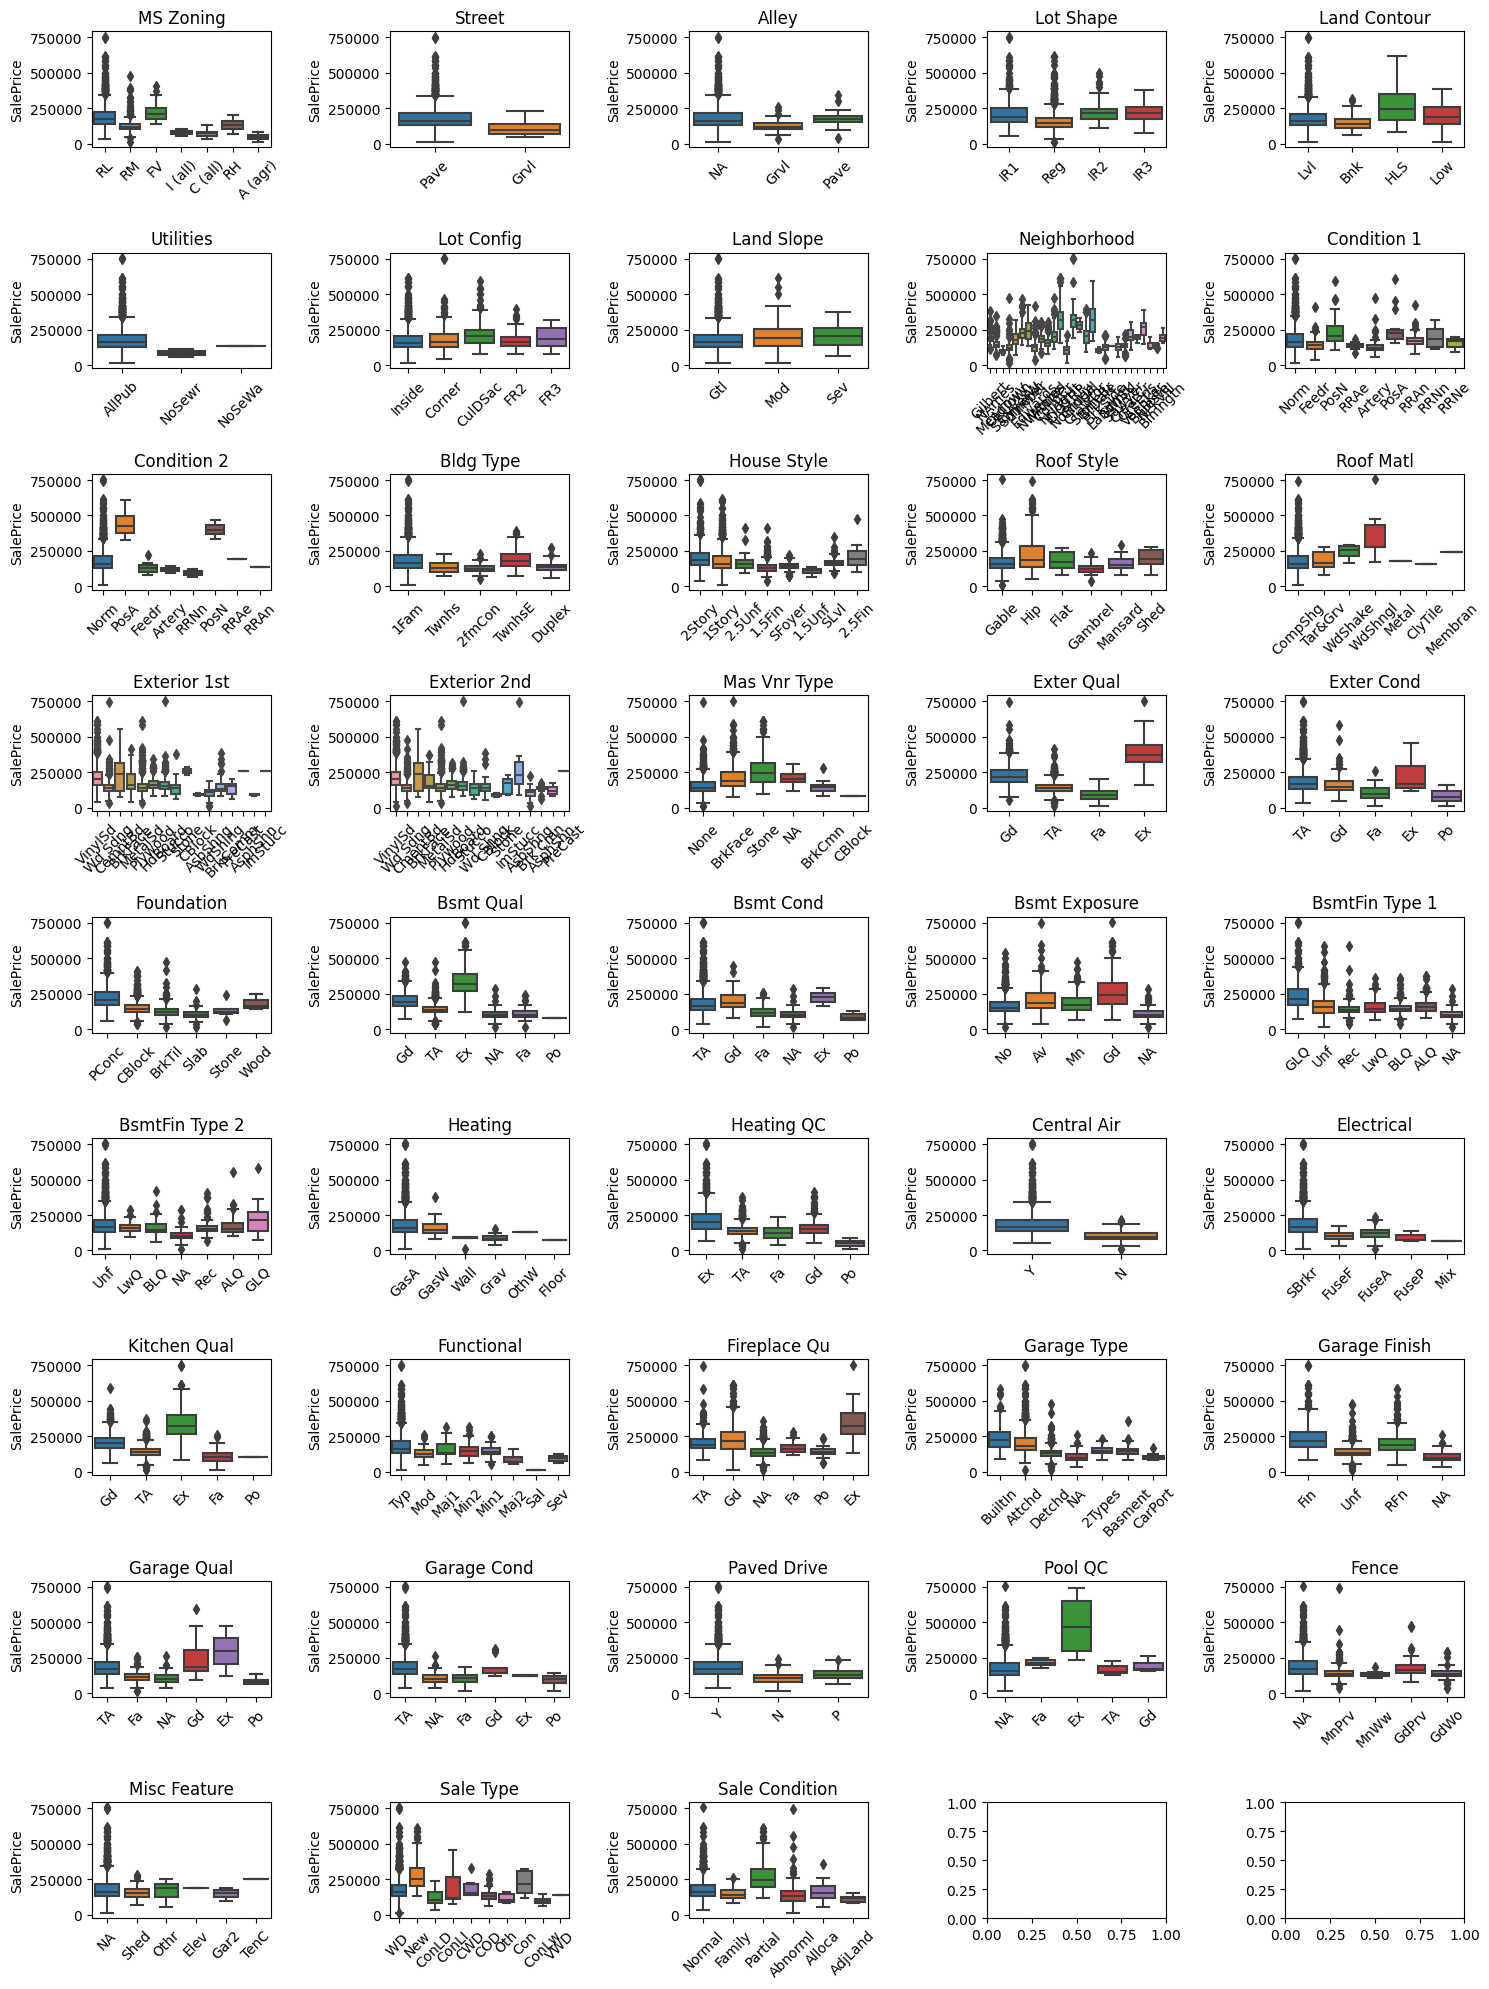

In [92]:
n_cols = 5
n_rows = 9

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 20))

for i, col in enumerate(categorical_features):
    r, c = np.divmod(i, n_cols)
    sns.boxplot(x=col, y='SalePrice', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    for label in axs[r, c].get_xticklabels():
        label.set_rotation(45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

__Observations__:
- There's a big diversity on how the categorical features relate to the 'Sale Price'
- For a few features there's a big effect, depending on the labels and specially for predicting high values of 'Sale Price', e.g. for 'neighbourhood', 'Condition 2', 'Pool Qc'
- For many of the ordinal features there seems to be trend that could be well adjusted by a linear relationship if the labels were ordered differently
- Other features show almost no correlation, e.g. 'Slope', 'Lot Config', 'Lot Shape'
- Additionally, others seem to show no effect with respect with most of the labels in the feature except for 1 or 2, e.g. 'Pool QC'  

In [93]:
df_categorical_missing = df[categorical_features].isna().sum().to_frame(name='total')
df_categorical_missing = df_categorical_missing[df_categorical_missing['total']!=0].sort_values('total', ascending=False)
df_categorical_missing['percentage'] = df_categorical_missing['total']/len(df)*100
df_categorical_missing.head()

,total,percentage


### Encoding

__Observation__:
- Features such as 'Exter Cond', 'Exter Cond', 'Garage Finish', have an ordinal nature despite being part of the categorical variables
- We can use this fact to directly encode them into a single numerical discrete variables, instead of using on-hot encoding

  
__Solution__:
- Encode the following categorical ordinal features as single variable: 'Lot Shape', 'Utilities', 'Land Slope', 'Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive'
- Assume a linear relationship between 'SalePrice' and all the categorical ordinal features (following observation of previous plots and information in documentation)
- Encode the remaining nominal features using "one-hot encoding"

In [94]:
encoding_order={
    'Lot Shape':['Reg', 'IR1', 'IR2', 'IR3'], 
    'Utilities':['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
    'Land Slope':['Gtl', 'Mod', 'Sev'],
    #'Overall Qual': ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1'],
    #'Overall Cond': ['10', '9', '8', '7', '6', '5', '4', '3', '2', '1'],
    'Exter Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Exter Cond':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Bsmt Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Bsmt Cond':['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Bsmt Exposure':['Gd', 'Av', 'Mn', 'No', 'NA'], 
    'BsmtFin Type 1':['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'BsmtFin Type 2':['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
    'Heating QC':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Electrical':['SBrkr', 'FuseA', 'FuseF', 'FuseP', 'Mix'],
    'Kitchen Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po'],
    'Functional':['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
    'Fireplace Qu':['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Garage Finish':['Fin', 'RFn', 'Unf','NA'],
    'Garage Qual':['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Garage Cond':['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
    'Paved Drive':['Y', 'P', 'N'],
    'Pool QC': ['Ex', 'Gd', 'TA', 'Fa', 'NA'],
    'Fence': ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'],
    }

ordinal_features = encoding_order.keys()
nominal_features = [col for col in categorical_features if col not in ordinal_features]

In [95]:
# Create an empty DataFrame to store the encoded columns
df_encoded = df.copy()

for feature, order in encoding_order.items():
    # convert feature to category with specified order
    df_encoded[feature] = pd.Categorical(df[feature], categories=order, ordered=True)

    # replace categories with numerical codes
    df_encoded[feature] = df_encoded[feature].cat.codes

In [96]:
# check if the features have been encoded correctly
for feature in ordinal_features:
    print(f'{feature}: {np.sort(df_encoded[feature].unique())}')

Lot Shape: [0 1 2 3]
Utilities: [0 1 2]
Land Slope: [0 1 2]
Exter Qual: [0 1 2 3]
Exter Cond: [0 1 2 3 4]
Bsmt Qual: [0 1 2 3 4 5]
Bsmt Cond: [0 1 2 3 4 5]
Bsmt Exposure: [0 1 2 3 4]
BsmtFin Type 1: [0 1 2 3 4 5 6]
BsmtFin Type 2: [0 1 2 3 4 5 6]
Heating QC: [0 1 2 3 4]
Electrical: [0 1 2 3 4]
Kitchen Qual: [0 1 2 3 4]
Functional: [0 1 2 3 4 5 6 7]
Fireplace Qu: [0 1 2 3 4 5]
Garage Finish: [0 1 2 3]
Garage Qual: [0 1 2 3 4 5]
Garage Cond: [0 1 2 3 4 5]
Paved Drive: [0 1 2]
Pool QC: [0 1 2 3 4]
Fence: [0 1 2 3 4]


### Correlations

__Correlations with target variable__

In [97]:
# compute correlation of ordinal features with SalePrice
ordinal_corr = df_encoded[ordinal_features].corrwith(df['SalePrice']).abs().sort_values(ascending=False)
print("Correlation of Ordinal Features SalePrice:")
print(ordinal_corr)

Correlation of Ordinal Features SalePrice:
Exter Qual       0.70
Kitchen Qual     0.67
Bsmt Qual        0.60
Garage Finish    0.55
Fireplace Qu     0.55
Heating QC       0.45
Bsmt Exposure    0.42
BsmtFin Type 1   0.35
Lot Shape        0.30
Garage Qual      0.28
Paved Drive      0.28
Garage Cond      0.26
Electrical       0.24
Bsmt Cond        0.21
Fence            0.16
Functional       0.13
Pool QC          0.12
Land Slope       0.07
Utilities        0.03
BsmtFin Type 2   0.02
Exter Cond       0.01
dtype: float64


## Numerical discrete features

In [98]:
print('Number of numerical discrete features:', len(discrete_features))

Number of numerical discrete features: 17


### Missing Values:

In [99]:
print(f'Total missing values: {df[discrete_features].isna().sum().sum()}')

Total missing values: 143


In [100]:
df_discrete_missing = df[discrete_features].isna().sum().to_frame(name='total')
df_discrete_missing = df_discrete_missing[df_discrete_missing['total']!=0].sort_values('total', ascending=False)
df_discrete_missing['percentage'] = df_discrete_missing['total']/len(df)*100
df_discrete_missing

,total,percentage
Garage Yr Blt,138,5.68
Bsmt Full Bath,2,0.08
Bsmt Half Bath,2,0.08
Garage Cars,1,0.04


__Observation__:
- 'Garage Yr Blt' is the feature with more missing values, these correspond to entries where there is no garage. It's not obvious which value to assign in these cases, the feature definition doesn't make sense for these cases.
- For 'Bsmt Full Bath', 'Bsmt Half Bath' and 'Garage Cars' the number of missing values is very small

__Solution__: 
- check correlation between 'Year Blt' and 'Garage Yr Blt', and if correlation is high we decide to drop the 'Garage Yr Blt' feature altogether
- For 'Bsmt Full Bath', 'Bsmt Half Bath' and 'Garage Cars', fill missing values with the mode.


In [101]:
df[df['Garage Yr Blt'].isna()]['Garage Type'].value_counts()

Garage Type
NA        136
Detchd      2
Name: count, dtype: int64

In [102]:
print(f"Correlation of 'Garage Yr Blt' with 'SalePrice': {df['Garage Yr Blt'].corr(df['Year Built'])}")

Correlation of 'Garage Yr Blt' with 'SalePrice': 0.835510232679516


As explained before, since the correlation is very high, we decide to drop the feature 'Garage Yr Blt'

In [103]:
df.drop('Garage Yr Blt', axis=1, inplace=True)
discrete_features = df.dtypes[df.dtypes == 'Int64'].index

In [104]:
# Replace missing values with the mode
features = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars']

for feature in features:
    mode_value = df[feature].mode()[0]
    df[feature].fillna(mode_value, inplace=True)

In [105]:
print(f"Missing values in discrete columns after cleaning: {df[discrete_features].isna().sum().sum()}")

Missing values in discrete columns after cleaning: 0


### Feature distribution:

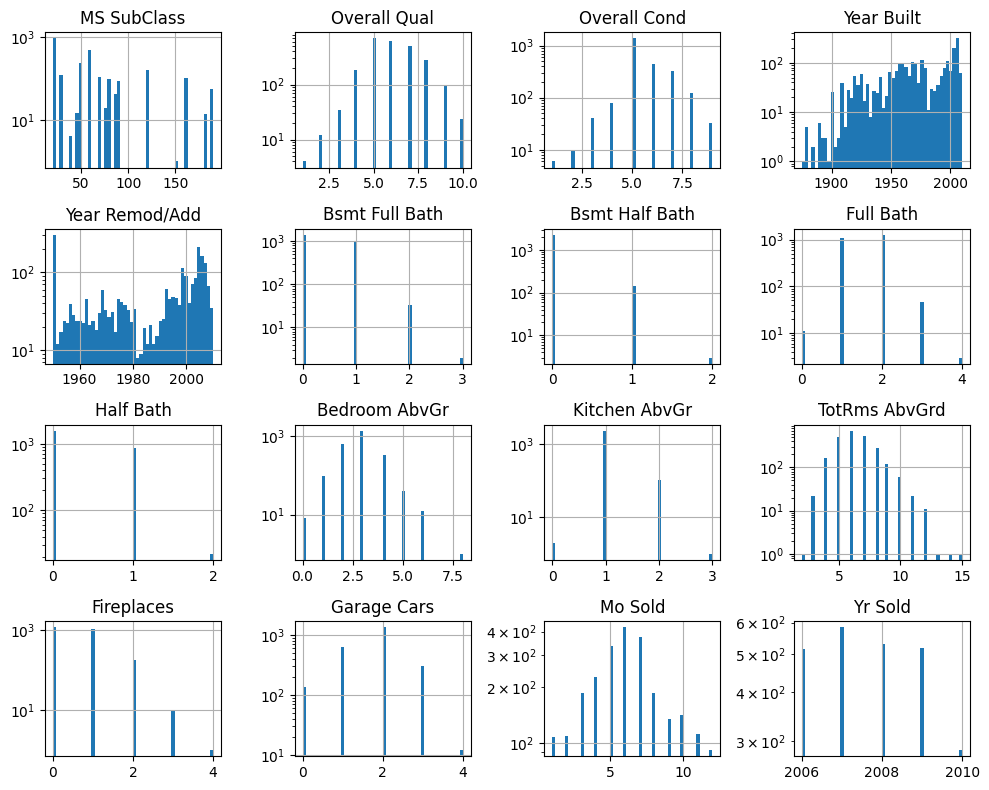

In [106]:
n_cols = 4
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 8))

for i, col in enumerate(discrete_features):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c], log=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

### Relationship with target variable

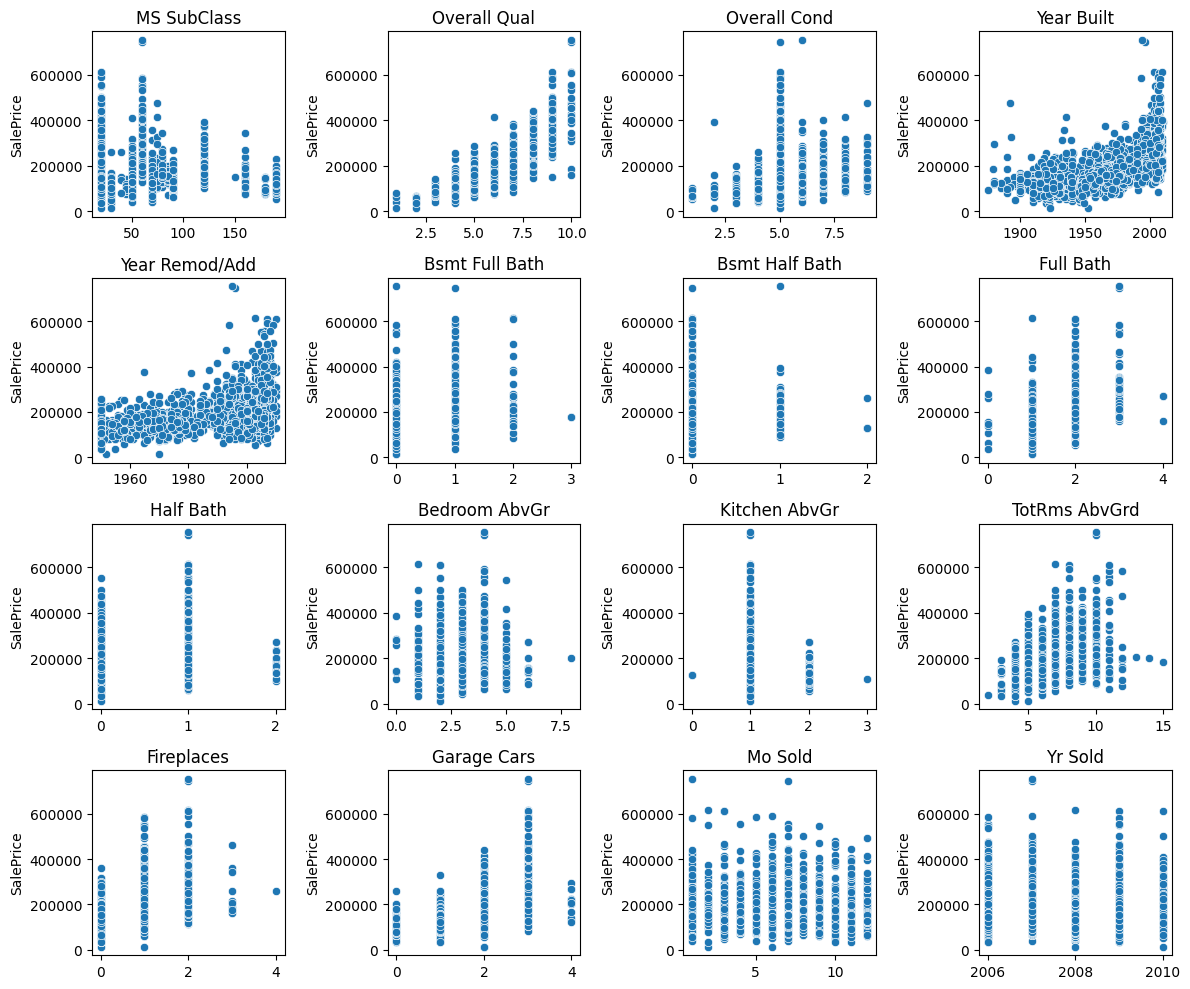

In [107]:
n_cols = 4
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,10))

for i, col in enumerate(discrete_features):
    r, c = np.divmod(i, n_cols)
    sns.scatterplot(x=col, y='SalePrice', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
#    for label in axs[r, c].get_xticklabels():
#        label.set_rotation(45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

### Correlations

__Correlation with target variable__

In [108]:
print("Correlation of Numerical Discrete features with SalePrice:")
df[discrete_features].corrwith(df['SalePrice']).abs().sort_values(ascending=False)


Correlation of Numerical Discrete features with SalePrice:


Overall Qual     0.80
Garage Cars      0.64
Year Built       0.56
Full Bath        0.54
Year Remod/Add   0.53
Fireplaces       0.49
TotRms AbvGrd    0.48
Half Bath        0.28
Bsmt Full Bath   0.28
Bedroom AbvGr    0.13
Kitchen AbvGr    0.12
Overall Cond     0.10
MS SubClass      0.09
Mo Sold          0.04
Bsmt Half Bath   0.03
Yr Sold          0.03
dtype: float64

__Correlation among features__

Correlation of numerical discrete among themselves:


<Axes: >

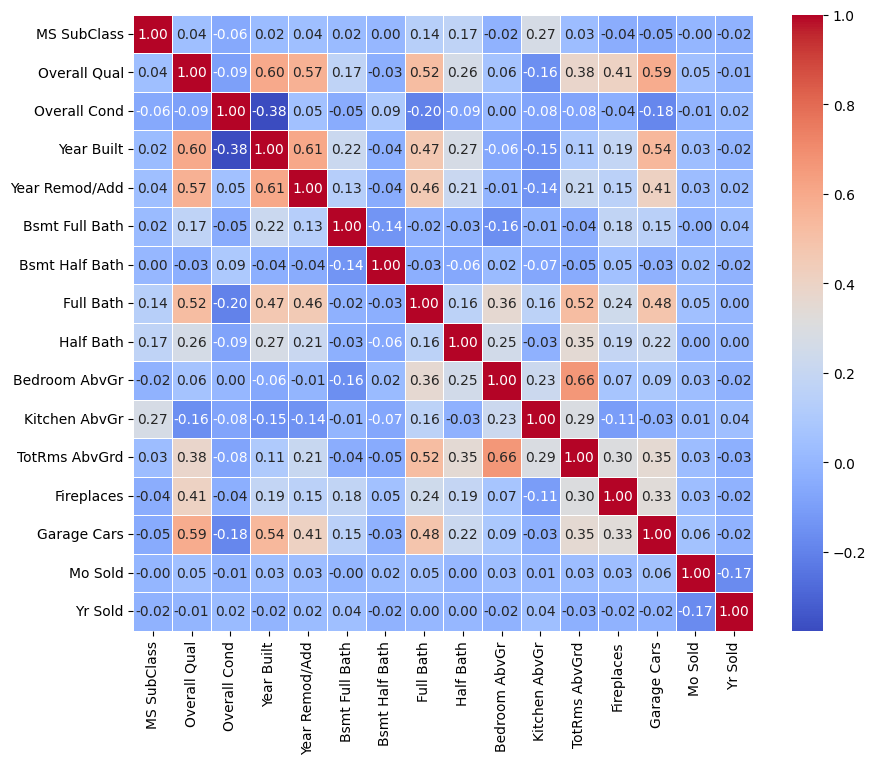

In [109]:
correlation_matrix = df[discrete_features].corr()

print("Correlation of numerical discrete among themselves:")
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

## Numerical continuous variable

In [110]:
print('Number of numerical continuous features:', len(continuous_features))

Number of numerical continuous features: 20


### Missing Values:

In [111]:
print(f"Missing values in continuous columns: {df[continuous_features].isna().sum().sum()}")

Missing values in continuous columns: 445


In [112]:
df_continuous_missing = df[continuous_features].isna().sum().to_frame(name='total')
df_continuous_missing = df_continuous_missing[df_continuous_missing['total']!=0].sort_values('total', ascending=False)
df_continuous_missing['percentage'] = df_continuous_missing['total']/len(df)*100
df_continuous_missing

,total,percentage
Lot Frontage,420,17.28
Mas Vnr Area,20,0.82
BsmtFin SF 1,1,0.04
BsmtFin SF 2,1,0.04
Bsmt Unf SF,1,0.04
Total Bsmt SF,1,0.04
Garage Area,1,0.04


__Observation__:
- Feature 'Lot Frontage' has a significant ammount of missing values, these could be from properties with no street connection, but this should be verified
- 'Mas Vnr Area' (Masonry veneer area in square feet) with missing values could also be coming from properties with no Masonry veneer surface

__Solution__:
- Observe relation between 'Lot Frontage' and 'Lot Config' for properties with no lot frontage.
- Check if missing values in 'Mas Vnr Area', also have 'Mas Vnr Type' equal to 'NA'
- If previous 

__Missing values in 'Lot Frontage':__

In [113]:
df[df['Lot Frontage'].isna()]['Lot Config'].value_counts()

Lot Config
Inside     235
Corner      86
CulDSac     79
FR2         17
FR3          3
Name: count, dtype: int64

Most missing values in 'Lot Frontage' correspond to lot configurations - 'Inside' and 'CulDSac' - where it seems likely that there's no street connection. We can reasonably assume that these missing values should correpond to 0 feet of street connection of the property.

In [114]:
df.loc[(df['Lot Config'].isin(['Inside', 'CulDSac'])) & (df['Lot Frontage'].isna()), 'Lot Frontage'] = 0

For the remaining missing values in the 'Lot Frontage' column, we will replace them with the median value (more robust to outliers than the mean).

In [115]:
# For the remaining missing values in the 'Lot Frontage' column, we will replace them with the median value.
median_value = df['Lot Frontage'].median()
df['Lot Frontage'].fillna(median_value, inplace=True)

__Missing values in 'Mas Vnr Area':__

In [116]:
df[df['Mas Vnr Area'].isna()]['Mas Vnr Type'].value_counts()

Mas Vnr Type
NA    20
Name: count, dtype: int64

All missing values in 'Mas Vnr Area' correspond to entries where 'Mas Vnr Type' is 'NA', hence it makes sense that these values should actually be zero.

In [117]:
df['Mas Vnr Area'].fillna(0, inplace=True)

__Missing values in 'BsmtFin SF', 'BsmtFin SF', 'Bsmt Unf SF':__

Next we look at the other missing values in some Basement related features. Below we see that the 3 missing values correspond to a single entry, and we decide to drop this entry. Where there's actually no basement (the values 5,4,6 for ordinal variables, after the encoding, correspond to 'NA' - No basement).

In [118]:
df[df['BsmtFin SF 1'].isna() | df['BsmtFin SF 2'].isna() | df['Bsmt Unf SF'].isna() | df['Total Bsmt SF'].isna()][['Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin SF 1','BsmtFin Type 1','BsmtFin SF 2', 'Bsmt Unf SF']]   

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 1,BsmtFin SF 2,Bsmt Unf SF
104,NA,NA,NA,NA,NaN,NA,NaN,NaN


Hence, we replace the missing Basement features by 0

In [119]:
df['BsmtFin SF 1'].fillna(0, inplace=True)
df['BsmtFin SF 2'].fillna(0, inplace=True)
df['Bsmt Unf SF'].fillna(0, inplace=True)
df['Total Bsmt SF'].fillna(0, inplace=True)

__Missing values in 'Garage Area':__

In [120]:
df[df['Garage Area'].isna() | df['Garage Type'].isna() | df['Garage Finish'].isna() | df['Garage Qual'].isna() | df['Garage Cond'].isna()][['Garage Area','Garage Cars','Garage Type','Garage Finish','Garage Qual','Garage Cond']]   

,Garage Area,Garage Cars,Garage Type,Garage Finish,Garage Qual,Garage Cond
1565,NaN,2,Detchd,NA,NA,NA


Since the entry with missing value in for 'Garage Area' presents rather inconsistent values for remaining garage variables we decide to drop this entry. For meaning of ordinal features values check previously defined encoding.

In [121]:
df.drop(index=1565,inplace=True)

After the previous cleanup, the following reduced number of features with missing values remain:

In [122]:
print(f"Missing values in numerical continuous features after cleaning: {df[continuous_features].isna().sum().sum()}")

Missing values in numerical continuous features after cleaning: 0


### Feature Distribution

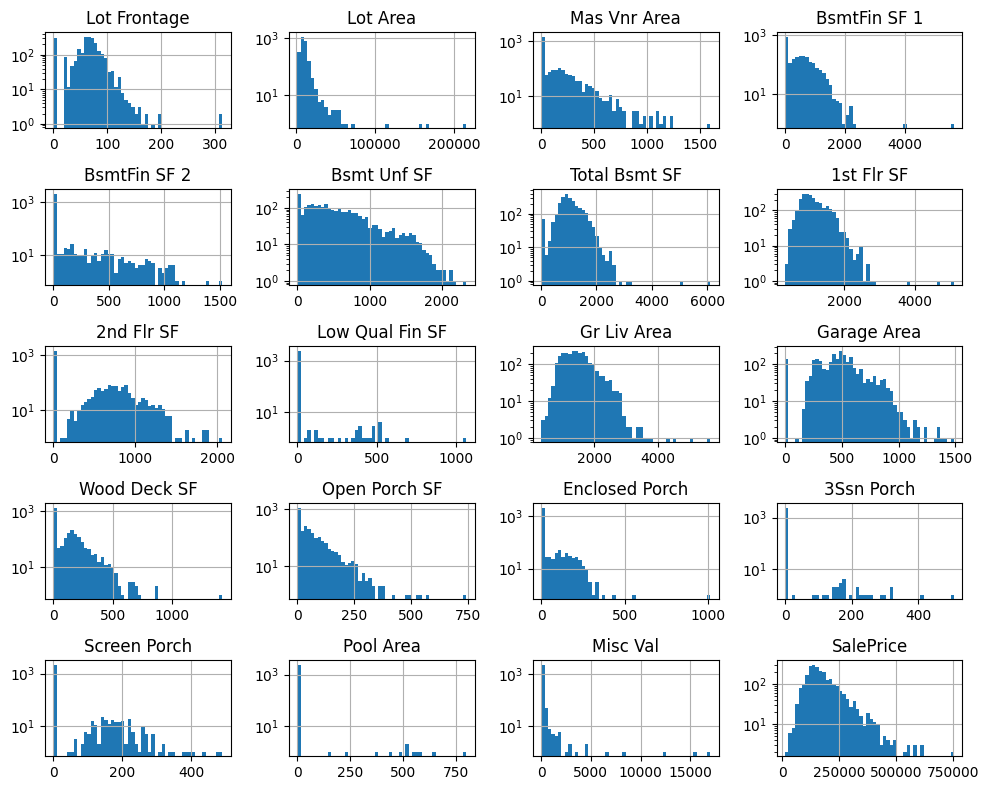

In [123]:
n_cols = 4
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,8))

for i, col in enumerate(continuous_features):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c], log=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

### Relationship with target variable

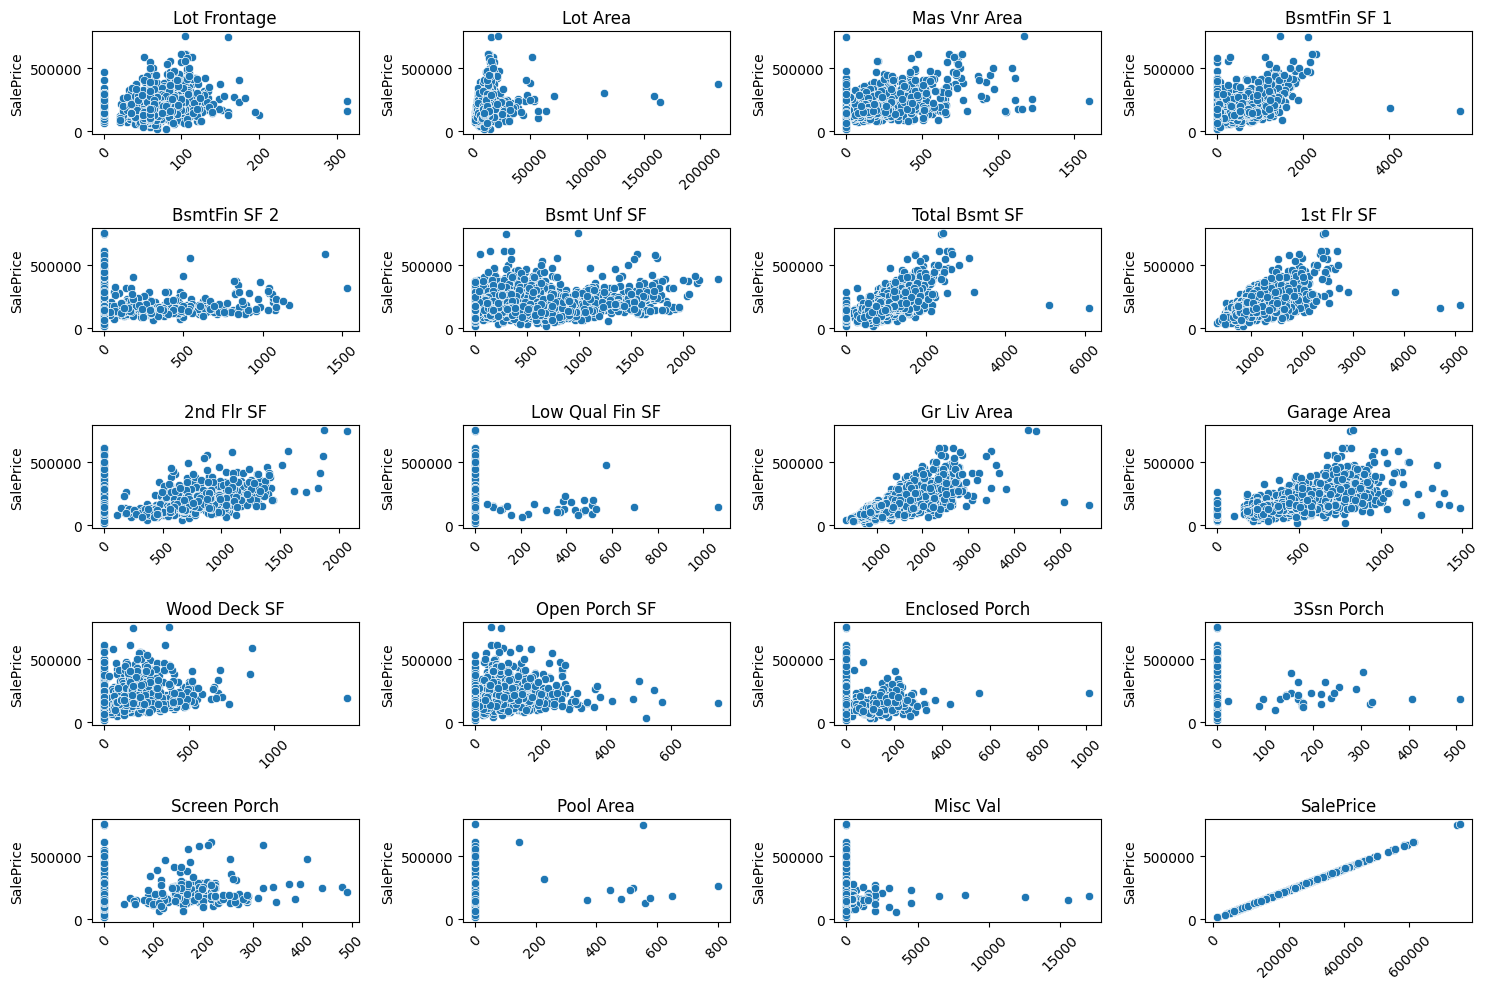

In [124]:
n_cols = 4
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15,10))

for i, col in enumerate(continuous_features):
    r, c = np.divmod(i, n_cols)
    sns.scatterplot(x=col, y='SalePrice', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    for label in axs[r, c].get_xticklabels():
        label.set_rotation(45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

### Correlations

__Correlation with target variable__

In [125]:
correlations = df[continuous_features].corr()['SalePrice'].abs().sort_values(ascending=False)
print("Correlation of numerical continuous features with SalePrice:")
print(correlations)

Correlation of numerical continuous features with SalePrice:
SalePrice         1.00
Gr Liv Area       0.70
Total Bsmt SF     0.64
Garage Area       0.63
1st Flr SF        0.63
Mas Vnr Area      0.51
BsmtFin SF 1      0.44
Wood Deck SF      0.32
Open Porch SF     0.30
Lot Area          0.25
2nd Flr SF        0.25
Lot Frontage      0.21
Bsmt Unf SF       0.18
Enclosed Porch    0.14
Screen Porch      0.12
Pool Area         0.07
3Ssn Porch        0.04
Low Qual Fin SF   0.03
Misc Val          0.02
BsmtFin SF 2      0.01
Name: SalePrice, dtype: float64


__Correlation among feature variables__

Correlation of numerical continuous among themselves:


<Axes: >

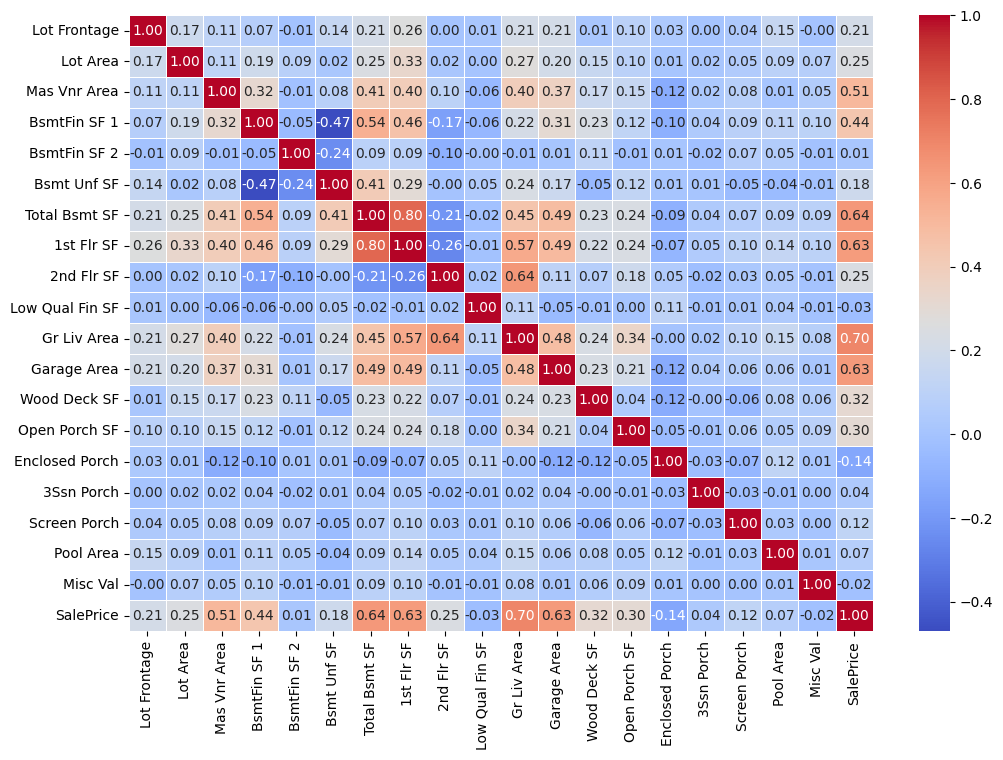

In [126]:
correlation_matrix = df[continuous_features].corr()

print("Correlation of numerical continuous among themselves:")
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)

## Inconsistencies

We start by looking at the possible values in the Categorical features

Next we'll analyse possible incosistencies among the following related variables:

- Basement variables
- Garage Year Built
- Finished vs living areas
- 'Year Built' vs 'Year Remod/Add'

### Basement variables

Next we check for possible inconsistencies in Basement related features with missing values

In [127]:
basement_features = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']

We start by looking at entries where at least one feature indicates 'NA', but where this is inconsistent witht he other features.

In [128]:
q1 = '(`Bsmt Qual` == "NA") | (`Bsmt Exposure` == "NA") | (`BsmtFin Type 1` == "NA") | (`BsmtFin Type 2` == "NA")'
q2 = '~((`Bsmt Qual` == "NA") & (`Bsmt Exposure` == "NA") & (`BsmtFin Type 1` == "NA") & (`BsmtFin Type 2` == "NA") & (`BsmtFin SF 1` == 0.00) & (`BsmtFin SF 2` == 0.00) & (`Bsmt Unf SF` == 0.00) & (`Total Bsmt SF` == 0.00) & (`Bsmt Full Bath` == 0) & (`Bsmt Half Bath` == 0))'
df.query(q1).query(q2)[basement_features]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
602,Gd,TA,No,GLQ,1124.00,NA,479.00,1603.00,3206.00,1,0
875,Gd,TA,NA,Unf,0.00,Unf,0.00,1595.00,1595.00,0,0
1681,Gd,TA,NA,Unf,0.00,Unf,0.00,725.00,725.00,0,0
1726,Gd,TA,NA,Unf,0.00,Unf,0.00,936.00,936.00,0,0


__Observation__:
- The previous entries show some kind of inconsistency, among the variables describing the basement facilities

__Solution__:
- Since these are only a few entries, we'll fix the entries using common sense
- We'll populate the column `'Bsmt Exposure'` of entries 875, 1681 and 1726, where  indicates there is no basement but we there's a basement in Unfinished conditions, with `'Bsmt Exposure'=='No'` that indicates no exposure to outside

In [129]:
df.loc[104, ['BsmtFin SF 1','BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']] = 0
df.loc[602, ['BsmtFin Type 2']] = 'Unf'
df.loc[[875,1681, 1726], ['Bsmt Exposure']] = 'No'

Next we check for potential inconsistencies among the various surface features.

In [130]:
inconsistent_basement_surface = (df['BsmtFin SF 1'] + df['BsmtFin SF 2'] + df['Bsmt Unf SF']) != df['Total Bsmt SF']
inconsistent_basement_surface.sum()

0

__Observation__:
- The Basement surface features are consistent among for all entries

### Garage Variables

In [131]:
garage_features = ['Garage Type', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']

Again, we start by looking at entries where at least one feature indicates 'NA', but where this is inconsistent witht he other features.

In [132]:
q1 = '(`Garage Type` == "NA") | (`Garage Finish` == "NA") | (`Garage Cars` == 0) | (`Garage Area` == 0) | (`Garage Qual` == "NA") & (`Garage Cond` == "NA")'
q2 = '~((`Garage Type` == "NA") & (`Garage Finish` == "NA") & (`Garage Cars` == 0) & (`Garage Area` == 0) & (`Garage Qual` == "NA") & (`Garage Cond` == "NA"))'
df.query(q1).query(q2)[garage_features]

,Garage Type,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
1114,Detchd,NA,1,360.00,NA,NA


__Observation__:
- There are two entries with inconsistent values

__Solution__:
- We decide to drop these since they are just two

In [133]:
df.drop([1114, 1565], inplace=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 df.drop([1114, 1565], inplace=True)                                                          │
│   2                                                                                              │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/frame.py:5344 in drop                                                                        │
│                                                                                                  │
│    5341 │   │   falcon  speed   320.0   250.0                                                    │
│    5342 │   │   │   │   weight  1.0     0.8                                                      │
│    5343 │   │   """                                                                              │
│ ❱  5344 │   │   return super().drop(                                                             │
│    5345 │   │   │   labels=labels,                                                               │
│    5346 │   │   │   axis=axis,                                                                   │
│    5347 │   │   │   index=index,                                                                 │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/generic.py:4711 in drop                                                                      │
│                                                                                                  │
│    4708 │   │                                                                                    │
│    4709 │   │   for axis, labels in axes.items():                                                │
│    4710 │   │   │   if labels is not None:                                                       │
│ ❱  4711 │   │   │   │   obj = obj._drop_axis(labels, axis, level=level, errors=errors)           │
│    4712 │   │                                                                                    │
│    4713 │   │   if inplace:                                                                      │
│    4714 │   │   │   self._update_inplace(obj)                                                    │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/generic.py:4753 in _drop_axis                                                                │
│                                                                                                  │
│    4750 │   │   │   │   │   raise AssertionError("axis must be a MultiIndex")                    │
│    4751 │   │   │   │   new_axis = axis.drop(labels, level=level, errors=errors)                 │
│    4752 │   │   │   else:                                                                        │
│ ❱  4753 │   │   │   │   new_axis = axis.drop(labels, errors=errors)                              │
│    4754 │   │   │   indexer = axis.get_indexer(new_axis)                                         │
│    4755 │   │                                                                                    │
│    4756 │   │   # Case for non-unique axis                                                       │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school

### Year Built vs Year Remod/Add vs Year Sold 

We verify that the following conditions are verified:
-  'Yr Sold' >= 'Year Remod/Add'
- 'Year Remod/Add' >= 'Year Built' 

In [76]:
df[df['Year Remod/Add'] < df['Year Built']]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice


In [176]:
q = '(`Year Built` > `Yr Sold`)'
df.query(q)[['Year Built', 'Year Remod/Add', 'Yr Sold']]

,Year Built,Year Remod/Add,Yr Sold
71,2008,2009,2007


__Observation__:  
- No inconsistencies observed between 'Year Built' and 'Year Remod/Add'
- For entrie 71 the 'Yr Sold' should be at least 2009

__Solution__:  
- Manually change this value

In [177]:
# Change value of Yr SOld for entry 71 to 2009
df.loc[71,'Yr Sold'] = 2009

### Misc Feature and Misc Val

When there is no 'Misc Feature' the corresponding 'Misc Val' should be 0 

In [178]:
q = '(`Misc Feature` ==  "NA") & (`Misc Val` != 0)'
df.query(q)[['Misc Feature', 'Misc Val']]

,Misc Feature,Misc Val


__Observations__:  
- No inconsistencies observed

## Outliers

### Statistics of numerical features

__Min and Max values of Numerical continuous features__

In [86]:
df[continuous_features].describe().loc[['min', 'max']].T

,min,max
Lot Frontage,0.00,313.00
Lot Area,1470.00,215245.00
Mas Vnr Area,0.00,1600.00
BsmtFin SF 1,0.00,5644.00
BsmtFin SF 2,0.00,1526.00
Bsmt Unf SF,0.00,2336.00
Total Bsmt SF,0.00,6110.00
1st Flr SF,334.00,5095.00
2nd Flr SF,0.00,2065.00
Low Qual Fin SF,0.00,1064.00


__Min and Max values of Numerical discrete features__

In [89]:
df[discrete_features].describe().loc[['min', 'max']].T

,min,max
MS SubClass,20.00,190.00
Overall Qual,1.00,10.00
Overall Cond,1.00,9.00
Year Built,1875.00,2010.00
Year Remod/Add,1950.00,2010.00
Bsmt Full Bath,0.00,3.00
Bsmt Half Bath,0.00,2.00
Full Bath,0.00,4.00
Half Bath,0.00,2.00
Bedroom AbvGr,0.00,8.00


# Feature Engineering

# Dataset splitting

In [66]:
from sklearn.model_selection import train_test_split

# split the df dataset into training and validation sets
# Define the target variable and features
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 1457
Validation set size: 972


# Model evaluation

# Model fitting

__Model Evaluation Function__

In [169]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score#, root_mean_squared_error

def evaluate_model(model, X_test, y_test):
    # Predict target values
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    #rms = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    
    # Print MAE in dollars
    print(f"Mean Absolute Error (MAE): {mae/1000:.3f} thousand dollars")
    #print(f"Root Mean Squared Error (RMSE): {rms/1000:.3f} dollars")
    print(f"R-squared (R2): {r2:.2f}")

## Baseline model

In [170]:
baseline_model = LinearRegression()

# Reshape target mean to fit the LinearRegression format (as a single feature)
y_baseline = np.full((X_train.shape[0], 1), y_train.mean())

X_train_baseline = pd.DataFrame({'constant': np.ones(len(X_train))})
X_val_baseline = pd.DataFrame({'constant': np.ones(len(X_val))})

# Fit the baseline model to predict this constant mean value
baseline_model.fit(pd.DataFrame({'constant': np.ones(len(X_train))}), y_baseline)

LinearRegression()

In [171]:
evaluate_model(baseline_model, X_val_baseline, y_val)

Mean Absolute Error (MAE): 55.181 thousand dollars
R-squared (R2): -0.00


## Simple Model

__Observation__:
- The two variables with the highest correlation values with 'Sale Price' are: 'Gr Liv Area' and 'Overall Qual'  

__Solution__:
- Use these two features in the simple model as may provide higehet prediction power

In [172]:
from sklearn.linear_model import LinearRegression

# Create a linear regression object
model_simple = LinearRegression()

features_simple = ['Overall Qual', 'Gr Liv Area']


# Fit the model
model_simple.fit(X_train[features_simple], y_train)

LinearRegression()

In [173]:
evaluate_model(model_simple, X_val[features_simple], y_val)

Mean Absolute Error (MAE): 27.691 thousand dollars
R-squared (R2): 0.73


## Complex Model

In [183]:
from sklearn.linear_model import LinearRegression

# Create a linear regression object
model_simple = LinearRegression()

features_complex = continuous_features.drop(['SalePrice'])

# Fit the model
model_simple.fit(X_train[features_complex], y_train)

evaluate_model(model_simple, X_val[features_simple], y_val)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│    8 # Fit the model                                                                             │
│    9 model_simple.fit(X_train[features_complex], y_train)                                        │
│   10                                                                                             │
│ ❱ 11 evaluate_model(model_simple, X_val[features_simple], y_val)                                 │
│   12                                                                                             │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/frame.py:3899 in __getitem__                                                                 │
│                                                                                                  │
│    3896 │   │   else:                                                                            │
│    3897 │   │   │   if is_iterator(key):                                                         │
│    3898 │   │   │   │   key = list(key)                                                          │
│ ❱  3899 │   │   │   indexer = self.columns._get_indexer_strict(key, "columns")[1]                │
│    3900 │   │                                                                                    │
│    3901 │   │   # take() does not accept boolean indexers                                        │
│    3902 │   │   if getattr(indexer, "dtype", None) == bool:                                      │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/indexes/base.py:6114 in _get_indexer_strict                                                  │
│                                                                                                  │
│   6111 │   │   else:                                                                             │
│   6112 │   │   │   keyarr, indexer, new_indexer = self._reindex_non_unique(keyarr)               │
│   6113 │   │                                                                                     │
│ ❱ 6114 │   │   self._raise_if_missing(keyarr, indexer, axis_name)                                │
│   6115 │   │                                                                                     │
│   6116 │   │   keyarr = self.take(indexer)                                                       │
│   6117 │   │   if isinstance(key, Index):                                                        │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/indexes/base.py:6178 in _raise_if_missing                                                    │
│                                                                                                  │
│   6175 │   │   │   │   raise KeyError(f"None of [{key}] are in the [{axis_name}]")               │
│   6176 │   │   │                                                                                 │
│   6177 │   │   │   not_found = list(ensure_index(key)[missing_mask.nonzero()[0]].unique())       │
│ ❱ 6178 │   │   │   raise KeyError(f"{not_found} not in index")                                   │
│   6179 │                                                                                         │
│   6180 │   @overload                                       

In [178]:
features_complex

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Cars', 'Garage